# PULSE Model Comparison
This Colab notebook compares ANN with two-based models (Random Forest, Gradient Boosting), using best practices to select the most appropiated approach for PULSE.

In [17]:
!pip install numpy pandas scikit-learn matplotlib tensorflow

In [18]:
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Fix seeds
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


In [19]:
# Upload trends_computaex_data.csv before running this cell
df = pd.read_csv("trends_computaex_data.csv", sep=';')

X = df.drop(columns=["timestamp", "pue"]).values
y = df["pue"].values.reshape(-1, 1)

x_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)

y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


In [20]:
def build_ann_best(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


In [21]:
def evaluate_model_scaled(name, model, fit_kwargs=None):
    start = time.time()
    if fit_kwargs:
        model.fit(X_train, y_train, **fit_kwargs)
    else:
        model.fit(X_train, y_train)
    duration = time.time() - start
    y_pred = model.predict(X_test)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_rescaled = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    return {
        "Model": name,
        "R²": r2_score(y_test_rescaled, y_pred_rescaled),
        "MAE": mean_absolute_error(y_test_rescaled, y_pred_rescaled),
        "RMSE": np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled)),
        "Training Time (s)": duration
    }


In [22]:
results = []

# Train ANN
ann = build_ann_best(X_train.shape[1])
early_stop = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5)
history = ann.fit(
    X_train, y_train,
    epochs=300,
    batch_size=16,
    verbose=0,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

print(f"Training stopped at epoch: {len(history.history['loss'])}")

# Evaluate ANN
results.append(evaluate_model_scaled("ANN", ann))

# Tree models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
results.append(evaluate_model_scaled("Random Forest", rf))

gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
results.append(evaluate_model_scaled("Gradient Boosting", gb))

# Show results
results_df = pd.DataFrame(results)
results_df


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training stopped at epoch: 89
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4679e-04
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


,Model,R²,MAE,RMSE,Training Time (s)
0,ANN,0.927420,0.019948,0.032237,0.349761
1,Random Forest,0.970989,0.014863,0.020381,4.760743
2,Gradient Boosting,0.970970,0.015518,0.020388,2.158706


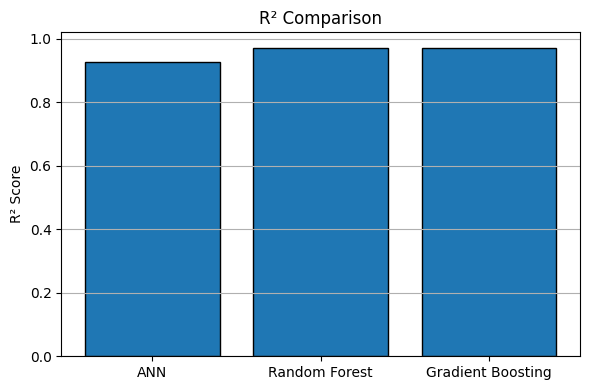

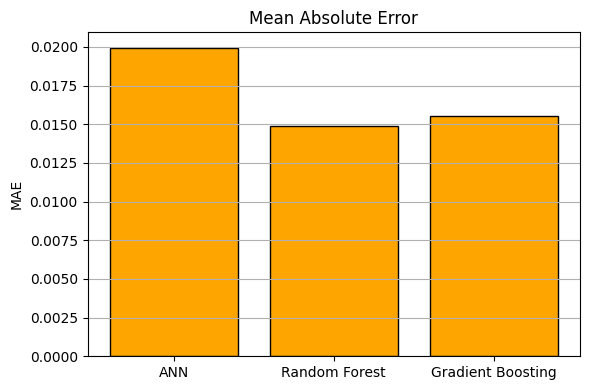

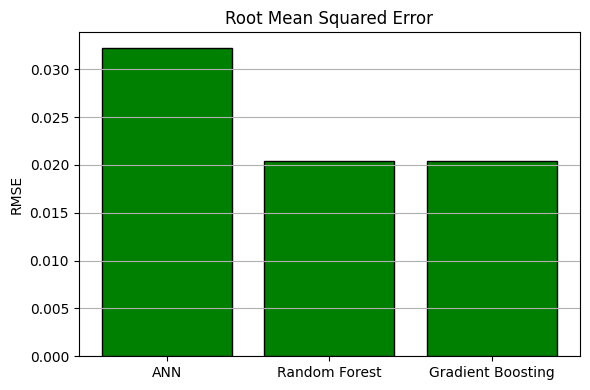

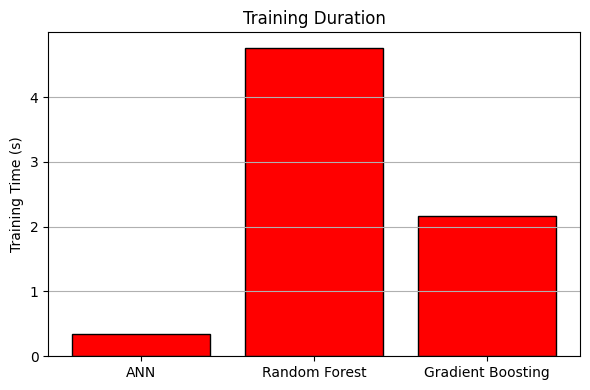

In [23]:
# R² Comparison
plt.figure(figsize=(6, 4))
plt.bar(results_df["Model"], results_df["R²"], edgecolor='black')
plt.ylabel("R² Score")
plt.title("R² Comparison")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# MAE
plt.figure(figsize=(6, 4))
plt.bar(results_df["Model"], results_df["MAE"], color='orange', edgecolor='black')
plt.ylabel("MAE")
plt.title("Mean Absolute Error")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# RMSE
plt.figure(figsize=(6, 4))
plt.bar(results_df["Model"], results_df["RMSE"], color='green', edgecolor='black')
plt.ylabel("RMSE")
plt.title("Root Mean Squared Error")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Training Time
plt.figure(figsize=(6, 4))
plt.bar(results_df["Model"], results_df["Training Time (s)"], color='red', edgecolor='black')
plt.ylabel("Training Time (s)")
plt.title("Training Duration")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


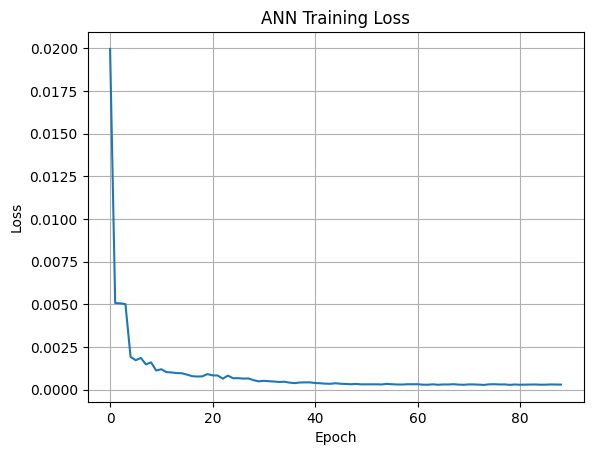

In [24]:
# Loss curve for ANN
plt.plot(history.history['loss'])
plt.title('ANN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


**Note:** The ANN achieved an R² of 0.927, with a MAE of 0.0199 and RMSE of 0.0322. While slightly below tree-based models in R² (0.971), its performance was comparable in error metrics and showed fast convergence with proper normalization and fixed seeds. The ANN was selected not only for its accuracy but for its integration potential. It supports lightweight deployment (e.g., TensorFlow Lite) and enables real-time use and future fine-tuning within the PULSE framework.
